# Relaxation methods for solving the Laplace or Poisson equation

Consider the one-dimensional Laplace equation 

$$\frac{d^2V}{dx^2}=0$$ 

which has the solution $V(x)=ax+b$, where $a$ and $b$ are constants determined by the boundary conditions. A common strategy for solving such a differential equation numerically is to start with an initial guess for the solution, and then gradually "relax" this guess towards the true solution through iteration. One way to do this is with the so-called "Gauss-Seidel" update rule. First we discretize the solution along the domain of interest, $x=j*a$, where $a$ is the step size. We fix the solution at the end points and update the values in between from iteration step $n$ to $n+1$ according to the equation

$$V_j^{n+1}=(V_{j+1}^n+V_{j-1}^{n+1})/2.$$ 

The sample program below illustrates this method for a choice of $V_0 = 0$ and $V_N = 10$. You can see how the (quite bad) initial guess evolves towards the correct solution as n increases.

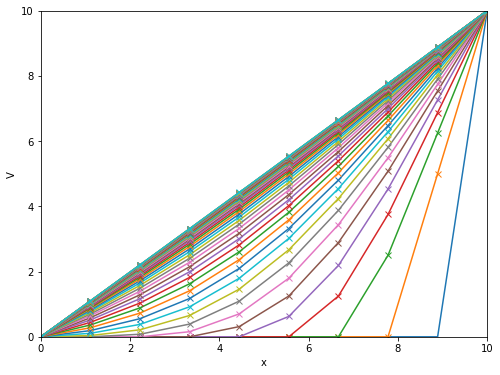

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N = 10       ## Number of points where we compute the solution

x = np.linspace(0,10,N)  ## Locations where we intend to solve the problem
V = np.zeros(N)         ## Place holder for V where all the guesses are zero

## Setting the boundary values
V[0] = 0
V[N-1] = 10

fig = plt.figure(figsize = (8,6))
plt.plot(x,V)
plt.xlabel('x')
plt.ylabel('V')
plt.axis([x[0],x[N-1],V[0],V[N-1]])

## Iterate the soluton and plot each result showing convergence
for j in range(1,50):    
    ## Compute the update (notice the end points are left out)
    for i in range(1,len(V)-1):
        V[i]=0.5*(V[i-1]+V[i+1])    
    plt.plot(x,V,"x-")  

fig.savefig('Method_Of_Relaxation_2D.png')

# Assignment

Generalize the procedure described above to two dimensions and solve in a compuational domain of size $N=50$

1. the Laplace equation $$\Delta V(r)=0$$
with the boundary conditions $V(x,0)=V(x,N)=\sin(\pi x/N)$ and $V(0,y)=V(N,y)=\sin(\pi y/N)$.


2. the Poisson equation $$\Delta V(r)=\delta^2 (r)=\delta(x)\delta(y)$$
i.e. place a unit charge at the origin. Set $V(x,y)=0$ everywhere on the boundary.

Present your answer by visualizing the 2D array $V(x,y)$. One quick way to do this is to use the matplotlib function ${\tt pcolor(V)}$, which creates a colour plot on a grid with the colour representing the local value of V.  


In [5]:
%load_ext Cython

Start part 1 at 0.0
Finish setting boundaries of part 1 at 0.0009999275207519531
Start calculations part 1 at 0.03789949417114258
Finish calculations part 1 at 2.2280433177948
Finish part 1 at 2.301016092300415
Start part 2 at 2.356947660446167
Finish setting boundaries of part 2 at 2.356947660446167
Start calculations part 2 at 2.381883144378662
Finish calculations part 2 at 4.539117336273193
---Completed this program in 4.651720762252808 seconds on Cython---


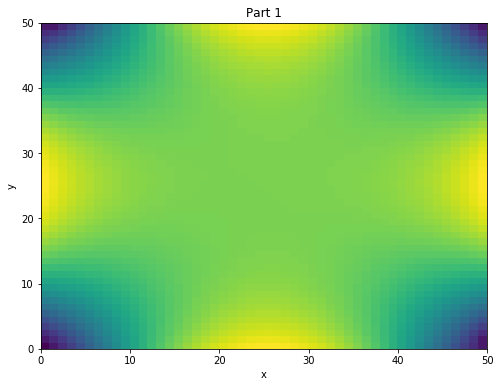

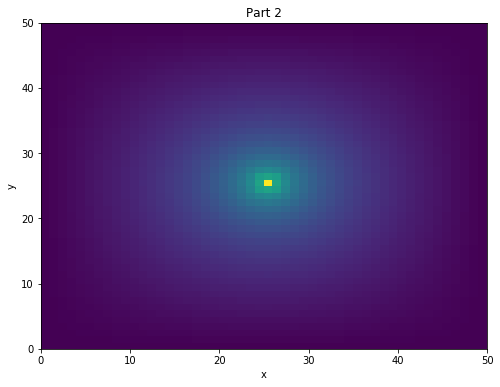

In [6]:
%%cython
## May need to run this twice for the plots to show
## Tested using Cython to optimize performance

# imports
import numpy as np
import matplotlib.pyplot as plt
import time

# cimports
cimport numpy as np
cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero

cdef double get_average_values(double[:,:] V, int x, int y):
    """Gets average value of 8 values around this point
    
    requires 0 < x,y < len(V)-1
    requires V be a square array of numbers
    """
    cdef:
        double sum
        double average
    
    sum = V[x-1][y-1] + V[x-1][y] + V[x-1][y+1] + V[x][y-1] + V[x][y+1] + V[x+1][y-1] + V[x+1][y] + V[x+1][y+1]
    average = sum / 8
    return average

cdef:
    double start_time = time.time()  # keep track of program run time
    int N = 50  # domain size
    int num_steps = 1000  # number of relaxation steps
    int i
    int j
    int k

############ PART 1 ############
print("Start part 1 at {0}".format(time.time()-start_time))
cdef:
    double[:,:] V_1 = np.zeros([N,N])  # Place holder for V where all the guesses are zero

## Setting the boundary values  
for i in range(0,N):
    V_1[i][0] = np.sin(np.pi * i / N)
    V_1[i][N-1] = np.sin(np.pi * i / N)
    V_1[0][i] = np.sin(np.pi * i / N)
    V_1[N-1][i] = np.sin(np.pi * i / N)
    
print("Finish setting boundaries of part 1 at {0}".format(time.time()-start_time))

## Setup plot
fig = plt.figure(figsize = (8,6))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Part 1')
plt.axis([0,N,0,N])

print("Start calculations part 1 at {0}".format(time.time()-start_time))
## Iterate the soluton and update
for j in range(1,num_steps):
    for i in range(1,len(V_1)-1):
        for k in range(1,len(V_1[0])-1):
            V_1[i][k]=get_average_values(V_1,i,k)

print("Finish calculations part 1 at {0}".format(time.time()-start_time))

## Plot voltage after completing calculations
plt.pcolor(V_1)
print("Finish part 1 at {0}".format(time.time()-start_time))
fig.savefig('Method_Of_Relaxation_Sin.png')
############ PART 2 ############
cdef:
    double infinite_voltage = 10**8  # approximation for voltage at origin from point charge
    double[:,:] V_2 = np.zeros([N,N])  # Place holder for V where all the guesses are zero
    int half_N = int(N/2)

print("Start part 2 at {0}".format(time.time()-start_time))

## Setting the boundary values
for i in range(0,N):
    V_2[i][0] = 0
    V_2[i][N-1] = 0
    V_2[0][i] = 0
    V_2[N-1][i] = 0
    
V_2[half_N][half_N] = infinite_voltage   
print("Finish setting boundaries of part 2 at {0}".format(time.time()-start_time))

## Setup plot
fig = plt.figure(figsize = (8,6))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Part 2')
plt.axis([0,N,0,N])

print("Start calculations part 2 at {0}".format(time.time()-start_time))
## Iterate the soluton and compute update
for j in range(1,num_steps):
    for i in range(1,len(V_2)-1):
        for k in range(1,len(V_2[0])-1):
            ## Ensure that voltage at origin does not change
            if not (i == half_N and k == half_N):
                V_2[i][k]=get_average_values(V_2,i,k)  

print("Finish calculations part 2 at {0}".format(time.time()-start_time))

## Plot voltage after completing calculations
plt.pcolor(V_2)
fig.savefig('Method_Of_Relaxation_Delta.png')

print("---Completed this program in {0} seconds on Cython---".format(time.time()-start_time))